In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.stats.mstats import winsorize
from random import seed
from random import random
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

def load_data(load):
    spot = pd.read_csv(f'data/spot_{load}_usdt_1h.csv', parse_dates=['timestamp'])
    perp = pd.read_csv(f'data/perp_{load}_usdt_1h.csv', parse_dates=['timestamp'])
    perp.sort_values(by = 'epoch', ascending=True, inplace=True)
    spot.sort_values(by = 'epoch', ascending=True, inplace=True)
    perp = perp.reset_index(drop=True)
    spot = spot.reset_index(drop=True)
    funding_rate = pd.read_csv(f'data/rate_{load}_usdt.csv', parse_dates=['timestamp'])
    perp['close'] = perp['close'].shift(1)
    perp = perp.dropna(subset = ['close']).reset_index(drop = True)
    spot['close'] = spot['close'].shift(1)
    spot = spot.dropna(subset = ['close']).reset_index(drop = True)
    return spot, perp, funding_rate

def create_panel(spot, perp, funding_rate):
    panel = perp[['epoch', 'timestamp', 'close', 'usd_volume']]
    panel['day'] = panel['timestamp'].dt.round('D')
    panel = panel.rename(columns={'close': 'perp', 'usd_volume': 'perp_usd_volume'})
    panel = pd.merge(panel, spot[['epoch', 'close', 'usd_volume']], on='epoch', how='left')
    panel = panel.rename(columns={'close': 'spot', 'usd_volume': 'spot_usd_volume'})
    panel = pd.merge(panel, funding_rate[['epoch', 'funding_rate']], on='epoch', how='left')
    panel.sort_values(by = 'epoch', ascending=True, inplace=True)
    panel = panel.reset_index(drop=True)
    return panel

currencies = ['btc', 'eth', 'bnb', 'doge', 'ada']
panel_all = []
for i in range (0,len(currencies)):
    spot, perp, funding_rate = load_data(currencies[i])
    panel_temp = create_panel(spot, perp, funding_rate)
    panel_all.append(panel_temp)

cutoff = '2022-11-14 00:00:00'

start_lst = ['2019-09-10 08:00:00', '2019-11-27 07:00:00',
             '2020-02-10 08:00:00', '2020-07-10 09:00:00',
            '2020-01-31 08:00:00']
# eth_start = '2019-11-27 07:00:00'
# btc_start = '2019-09-10 08:00:00'
# doge_start = '2020-07-10 09:00:00'
# bnb_start = '2020-02-10 08:00:00'
# ada_start = '2020-01-31 08:00:00'

T = 1 / (3 * 365)

for i in range (0,len(currencies)):
    panel_all[i] = panel_all[i][panel_all[i]['timestamp'] <= cutoff]
    panel_all[i]['cip'] = (1/T)*(np.log(panel_all[i]['perp']) - np.log(panel_all[i]['spot'])) 
    panel_all[i] = panel_all[i][panel_all[i]['timestamp'] >= start_lst[i]]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


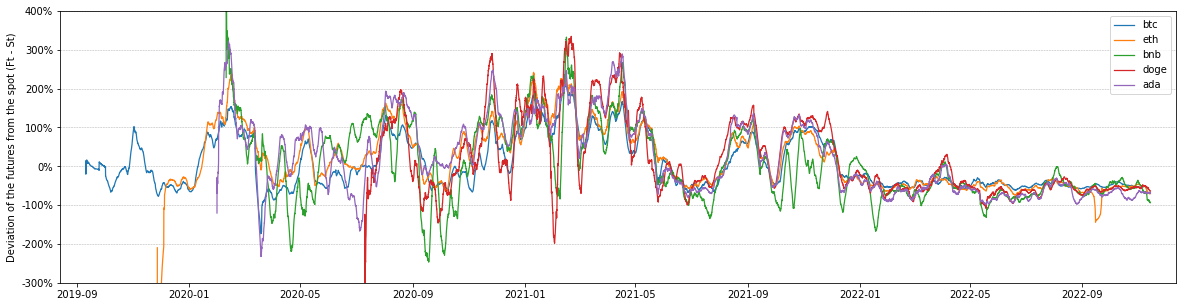

In [27]:
sns.color_palette()

panel_all[i].sort_values(by = 'epoch', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize =(20,5))

for i in range (0,len(currencies)):
    ax.plot(panel_all[i]['timestamp'], panel_all[i]['cip'].rolling(24*7, min_periods=1).mean(), linewidth=1.25)

ax.set_ylim(-3, 4)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


left, right = plt.xlim()
ax.set_xlim(left+30, right-30)

ax.legend(currencies, loc='upper right')
ax.set_ylabel('Deviation of the futures from the spot (Ft - St)')
ax.grid(axis='y', linestyle='--', linewidth=.5)
plt.savefig('figures_update/fig1.eps', format = 'eps', bbox_inches='tight')

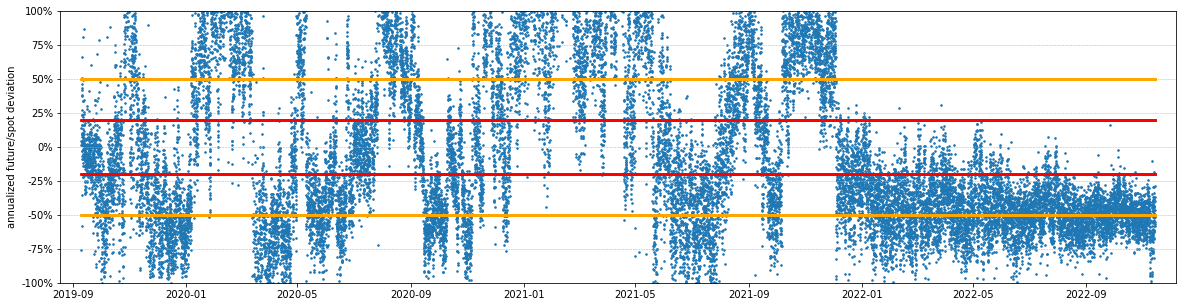

In [35]:
threshold = 0.5
threshold2 = 0.2

i = 0
#plotting the cip over time
sns.color_palette()
panel_all[i].sort_values(by = 'epoch', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize =(20,5))
ax.scatter(panel_all[i]['timestamp'], panel_all[i]['cip'], s=2.5)
ax.scatter(panel_all[i]['timestamp'], threshold * np.ones(len(panel_all[i]['cip'])), s = 2.5, color = 'orange')
ax.scatter(panel_all[i]['timestamp'], -threshold * np.ones(len(panel_all[i]['cip'])), s = 2.5, color = 'orange')
ax.scatter(panel_all[i]['timestamp'], threshold2 * np.ones(len(panel_all[i]['cip'])), s = 2.5, color = 'red')
ax.scatter(panel_all[i]['timestamp'], -threshold2 * np.ones(len(panel_all[i]['cip'])), s = 2.5, color = 'red')
ax.set_ylim(-1, 1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
left, right = plt.xlim()
ax.set_xlim(left+35, right-35)
# ax.legend(['future/spot', 'trading threshold'], loc='lower right')
ax.set_ylabel('annualized future/spot deviation')
ax.grid(axis='y', linestyle='--', linewidth=.5)
# plt.title(f'{currencies[i]}')
# plt.savefig(f'deviation_{i}.png')
# plt.savefig('figures_update/fig2.eps', format = 'eps', bbox_inches='tight')
plt.savefig('figures_update/fig2.png', bbox_inches = 'tight')

,perp_usd_volume,year
count,3.180000e+02,318.0
mean,1.381250e+10,2022.0
std,5.722708e+09,0.0
min,3.437351e+09,2022.0
25%,1.040389e+10,2022.0
50%,1.284860e+10,2022.0
75%,1.621240e+10,2022.0
max,4.055925e+10,2022.0


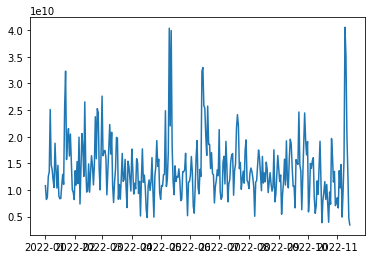

,perp_usd_volume,year
count,3.180000e+02,318.0
mean,7.869675e+09,2022.0
std,4.162191e+09,0.0
min,1.663720e+09,2022.0
25%,4.747405e+09,2022.0
50%,6.747642e+09,2022.0
75%,1.016107e+10,2022.0
max,3.176579e+10,2022.0


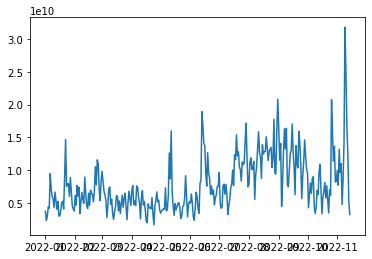

In [24]:
btc = panel_all[0]
eth = panel_all[1]

btc = btc.groupby('day').sum()['perp_usd_volume'].reset_index()
btc['year'] = btc['day'].apply(lambda x: x.year)
btc = btc[btc['year'] == 2022]

eth = eth.groupby('day').sum()['perp_usd_volume'].reset_index()
eth['year'] = eth['day'].apply(lambda x: x.year)
eth = eth[eth['year'] == 2022]

display(btc.describe())
plt.plot(btc['day'], btc['perp_usd_volume'])
plt.show()

display(eth.describe())
plt.plot(eth['day'], eth['perp_usd_volume'])
plt.show()